In [1]:
import os
import pickle
from openpyxl import load_workbook
import numpy as np
import matplotlib.pyplot as plt
import glob
# documentation for neo is here: http://neo.readthedocs.io/en/0.6/index.html
import neo
import efel
import quantities as pq
efel.setThreshold(0)

/Users/daniele/local/miniconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Function for loading ABF files

In [24]:
def load_abf_files(files):
    nfiles = len(files)
    cnt = 0
    for i,f in enumerate(files):
        print('Loading data from file [%s].' % f)
        # create a reader object
        reader = neo.io.AxonIO(f)
        # read the whole file as a block
        block = reader.read()
        # iterate over the segments in the block: each segment is a recording sweep
        nseg = len(block[0].segments)
        for j,segment in enumerate(block[0].segments):
            signal = segment.analogsignals[0]
            x = signal.as_array()
            if j == 0:
                if i == 0:
                    print('Allocating matrix of size (%d,%d).' % (nseg,len(x)))
                    X = np.zeros((nseg,len(x)))
                else:
                    if nsamples == X.shape[1]:
                        print('Increasing matrix size to (%d,%d).' % (X.shape[0]+nseg,len(x)))
                        X_new = np.zeros((X.shape[0]+nseg,len(x)))
                        X_new[:X.shape[0],:] = X
                        X = X_new
                    else:
                        print('Skipping file [%s]: data size does not match.' % f)
                        break
            duration = float(signal.duration)
            X[cnt,:] = x[:,0]
            cnt += 1
    srate = X.shape[1] / duration
    T = np.arange(X.shape[1])/srate
    return T,X

#### Returns True if the file contains a voltage recording

In [3]:
def contains_voltage_recording(filename):
    import quantities as pq
    reader = neo.io.AxonIO(filename)
    block = reader.read()
    return block[0].segments[0].analogsignals[0].units == pq.millivolt

#### Fit the I-V curve with a linear polynomial

In [4]:
def fit_IV_curve(dV,I):
    p = np.polyfit(I,dV,1)
    Rin = p[0]
    offset = p[1]
    return Rin,offset

def compute_input_resistance(features,Idc):
    # Idc in pA, Rin in MOhm
    dV = np.array([feat['voltage_deflection'][0] for feat in features if feat['Spikecount'][0] == 0])
    I = np.array([idc for feat,idc in zip(features,Idc) if feat['Spikecount'][0] == 0])
    idx, = np.where(I>0)
    Rin,offset = fit_IV_curve(dV[:idx[0]+1],I[:idx[0]+1])
    return Rin,offset,I,dV

#### Fit the f-I curve with a power law function

In [5]:
def fit_fI_curve(I,firing_rate):
    import scipy.optimize as opt
    power_law = lambda x,a,b,c: a*x**b+c
    idx, = np.where(firing_rate <= 0)
    x = I[idx[-1]:]
    y = firing_rate[idx[-1]:]
    p = np.polyfit(x,y,1)
    popt,pcov = opt.curve_fit(power_law,x,y,p0=[p[0],1,p[1]],maxfev=20000)
    a = popt[0]
    b = popt[1]
    c = popt[2]
    if c < 0:
        rheobase = (-c/a)**(1/b)
    else:
        rheobase = (c/a)**(1/b)
    return a,b,c,rheobase

#### Function for extracting features from a cell: loads the data and extracts the features

In [16]:
feature_names = ['Spikecount','mean_frequency','time_to_first_spike',
                 'peak_voltage','peak_time',
                 'spike_half_width','AP_width',
                 'AP_amplitude','min_AHP_values','AP_begin_voltage',
                 'ISI_CV','adaptation_index2',
                 'voltage_base','time_constant','voltage_deflection']

# NOTE that mean_frequency is defined as the number of peaks divided by the
# time to the last spike: this may lead to strange values if the cell does
# NOT spike regularly

# it makes sense to use voltage_base if the cells are not held at a certain
# resting potential by current injection

def extract_features_from_cell(filename, t0=120., dur=500.):
    if not contains_voltage_recording(filename):
        raise Exception('%s does not contain voltage traces' % filename)
    t,V = load_abf_files([filename])
    t = t*1e3
    traces = []
    for v in V:
        traces.append({'T': t, 'V': v, 'stim_start': [t0], 'stim_end': [t0+dur]})
    features = efel.getFeatureValues(traces,feature_names)
    return features,t,V

#### Function for preprocessing individual cells

In [21]:
def preprocess_cell(filename,t0,dur,Istep,Imin=None):
    
    try:
        features,t,V = extract_features_from_cell(filename,t0,dur)
    except:
        print('[%s] does not contain voltage traces.' % filename)
        return
    
    ### resting membrane potential
    Vrest = np.mean([f['voltage_base'][0] for f in features])
    ### membrane time constant
    time_constant = np.mean([f['time_constant'][0] for f in features if f['time_constant'] is not None])
    
    ### guess the amplitude of the injected current steps
    nsteps = V.shape[0]
    
    if nsteps == 1:
        return

    if not Imin is None:
        Idc = Imin + np.arange(nsteps)*Istep
    else:
        # finds the sweep corresponding to I = 0 pA
        i = np.argmin(np.std(V,1))
        # all the DC values of injected current
        Idc = (np.arange(nsteps)-i)*Istep
    
    ### compute the input resistance of the cell
    Rin,Rin_offset,Rin_I,Rin_dV = compute_input_resistance(features,Idc)
    print('Input resistance = %.0f MOhm.' % (Rin*1e3))
    
    ### fit the f-I curve of the cell
    try:
        firing_rate = np.array([feat['mean_frequency'][0] if feat['Spikecount'] > 0 else 0. for feat in features])
        a,b,c,rheobase = fit_fI_curve(Idc,firing_rate)
        print('Rheobase = %.0f pA.' % rheobase)
        I_slope = 2*rheobase
        slope = b*a*I_slope**(b-1)    # sp/s/pA
        offset = (power_law(I_slope,a,b,c)-slope*I_slope)
        print('The slope of the f-I curve at two times the rheobase is %.4f spikes/s/pA.' % slope)
    except:
        rheobase = None
        I_slope = None
        slope = None
        print('Could not fit the f-I curve.')
        
    data = {'features': features, 'Vrest': Vrest, 'time_constant': time_constant, \
            'Rin': Rin*1e3, 'rheobase': rheobase, 'Idc': Idc, \
           'firing_rate': firing_rate, 'I_slope': I_slope, 'fI_slope': slope, \
           't0': t0, 'dur': dur, 'Istep': Istep, 'Imin': Imin}
    pickle.dump(data, open(filename[:-4] + '.pkl', 'wb'))
    
    #### plot the results
    ms = 4
    plt.figure(figsize=(9,7))

    # V-I curve
    x = np.array([Rin_I[0]-Istep,Rin_I[-1]+Istep])
    y = Rin*x + Rin_offset
    plt.subplot(2,2,1)
    plt.plot(x,y,'r')
    plt.plot(Rin_I,Rin_dV,'ko',markersize=ms)
    plt.plot(plt.xlim(),np.array([0,0]),'--',color=[.6,.6,.6])
    plt.plot([0,0],plt.ylim(),'--',color=[.6,.6,.6])
    plt.xlabel('Injected current (pA)')
    plt.ylabel('Voltage deflection (mV)')
    plt.text(plt.xlim()[1]-np.diff(plt.xlim())/30, plt.ylim()[0]+np.diff(plt.ylim())/10,\
             'Rin = %.0f MOhm' % (Rin*1e3), horizontalalignment='right')
    
    num_spikes = np.array([feat['Spikecount'][0] for feat in features])
    print('There are %d sweeps containing spikes.' % len(np.where(num_spikes>0)[0]))
    if np.max(num_spikes) == 0:
        plt.suptitle(filename)
        plt.savefig(filename[:-4] + '.pdf', dpi=600)
        plt.show()
        return

    # f-I curve
    if not rheobase is None:
        x = np.linspace(rheobase,Idc[-1])  # nA
        y = power_law(x,a,b,c)             # sp/s
        xx = np.array([1.2*rheobase,2.8*rheobase])
        yy = slope*xx + offset
        plt.subplot(2,2,2)
        plt.plot(xx,yy,'b')
        plt.plot(x,y,'r')
        plt.plot(I_slope,power_law(I_slope,a,b,c),'cs',markersize=7)
        plt.plot(rheobase*np.ones(2),plt.ylim(),'g--')
        plt.plot(Idc,firing_rate,'ko',markersize=ms)
        plt.xlabel('Injected current (pA)')
        plt.ylabel('Firing rate (AP/s)')
        plt.text(plt.xlim()[1]-np.diff(plt.xlim())/30, plt.ylim()[0]+np.diff(plt.ylim())/5,\
                 'rheobase = %.0f pA' % rheobase, horizontalalignment='right')
        plt.text(plt.xlim()[1]-np.diff(plt.xlim())/30, plt.ylim()[0]+np.diff(plt.ylim())/10,\
                 'slope = %.3f sp/s/pA' % slope, horizontalalignment='right')
    
    # plot one voltage trace
    first = np.where(num_spikes>0)[0][0]
    accommodation_index = np.array([feat['adaptation_index2'][0] if feat['adaptation_index2'] \
                                    is not None else np.nan for feat in features])
    #print(accommodation_index)
    mean_accommodation_index = np.nanmean(accommodation_index)
    i = 0
    
    plt.subplot(2,2,3)
    plt.plot(t,V[first+i,:],'k',lw=1)
    plt.plot(features[first+i]['peak_time'],features[first+i]['peak_voltage'],'ro',markersize=ms)
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage (mV)')
    plt.xlim([t0-50,t0+dur+100])
    yl = plt.ylim()
    plt.text(t0+dur/2,plt.ylim()[0]+np.diff(plt.ylim())/20,\
             'acc. index = %.4f' % accommodation_index[first+i],\
             horizontalalignment='center')
    plt.subplot(2,2,4)
    plt.plot(t,V[first+i,:],'k',lw=1)
    plt.plot(t0+features[first+i]['time_to_first_spike'][0]+np.array([0,0]),plt.ylim(),'r--')
    plt.plot(plt.xlim(),features[first+i]['AP_begin_voltage'][0]+np.array([0,0]),'g--')
    plt.plot(plt.xlim(),features[first+i]['AP_begin_voltage'][0]+\
             features[first+i]['AP_amplitude'][0]+np.array([0,0]),'m--')
    plt.plot(plt.xlim(),features[first+i]['min_AHP_values'][0]+np.array([0,0]),'b--')
    plt.xlabel('Time (ms)')
    plt.xlim(t0+features[first+i]['time_to_first_spike'][0]+np.array([-3,7]))
    plt.ylim(yl)
    
    plt.suptitle(filename)
    
    plt.savefig(filename[:-4] + '.pdf', dpi=600)
    plt.show()

#### Preprocess all cells

[Recordings_Raw_Data/2018_01_08_0010.abf] does not contain voltage traces.
[Recordings_Raw_Data/2018_01_08_0016.abf] does not contain voltage traces.
[Recordings_Raw_Data/2018_01_08_0023.abf] does not contain voltage traces.
[Recordings_Raw_Data/2018_01_08_0030.abf] does not contain voltage traces.
Loading data from file [Recordings_Raw_Data/2018_01_18_0023.abf].
Allocating matrix of size (20,26000).


/Users/daniele/local/miniconda2/lib/python2.7/site-packages/efel/api.py:379: RuntimeWarning: Error while calculating feature mean_frequency: Parameter [offset] is missing in double map. In the python interface this can be set using the setDoubleSetting() function
Parameter [offset] is missing in double map. In the python interface this can be set using the setDoubleSetting() function
Parameter [offset] is missing in double map. In the python interface this can be set using the setDoubleSetting() function
Parameter [offset] is missing in double map. In the python interface this can be set using the setDoubleSetting() function

Voltage never goes below or above threshold in spike detection.

  RuntimeWarning)


Input resistance = 159 MOhm.
Rheobase = 106 pA.
The slope of the f-I curve at two times the rheobase is 0.2112 spikes/s/pA.
There are 10 sweeps containing spikes.


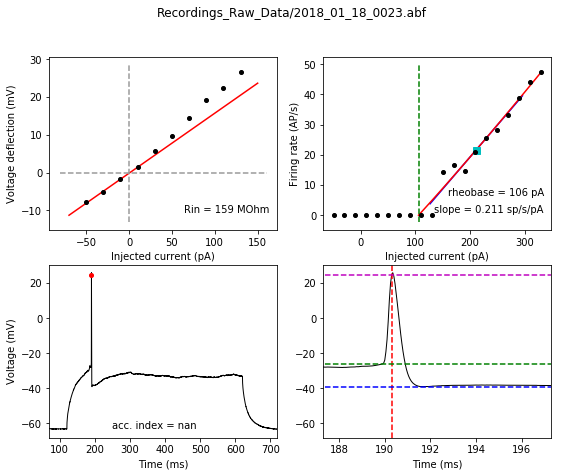

Loading data from file [Recordings_Raw_Data/2018_01_22_0000.abf].
Allocating matrix of size (20,26000).


/Users/daniele/local/miniconda2/lib/python2.7/site-packages/efel/api.py:379: RuntimeWarning: Error while calculating feature ISI_CV: Parameter [offset] is missing in double map. In the python interface this can be set using the setDoubleSetting() function
Parameter [offset] is missing in double map. In the python interface this can be set using the setDoubleSetting() function
Parameter [offset] is missing in double map. In the python interface this can be set using the setDoubleSetting() function
Parameter [offset] is missing in double map. In the python interface this can be set using the setDoubleSetting() function
Parameter [offset] is missing in double map. In the python interface this can be set using the setDoubleSetting() function
Parameter [offset] is missing in double map. In the python interface this can be set using the setDoubleSetting() function
Parameter [offset] is missing in double map. In the python interface this can be set using the setDoubleSetting() function
Parame

Input resistance = 474 MOhm.
Rheobase = 11 pA.
The slope of the f-I curve at two times the rheobase is 0.5078 spikes/s/pA.
There are 17 sweeps containing spikes.


IndexError: index 0 is out of bounds for axis 0 with size 0

In [27]:
# start time of the stimulation
t0 = 120.    # ms
# duration of the stimulation
dur = 500.   # ms
# minimum current step
Imin = -50.  # pA
# step of current
Istep = 20.  # pA

basepath = 'Recordings_Raw_Data/'
excel_file = 'PatchSeq_files_for_analysis_26092019.xlsx'
wb = load_workbook(filename=excel_file)
sheet = wb['IDs']
header = True
files = [basepath+cell.value+'.abf' for cell in wb['IDs']['E'] if not cell.value is None]
files = files[1:]

power_law = lambda x,a,b,c: a*x**b+c
force = False
for f in files:
    if force or not os.path.isfile(f[:-4]+'.pkl'):
        preprocess_cell(f,t0,dur,Istep,Imin)
    